In [52]:
import emoji, emot, re, stylecloud

import pandas as pd
import plotly.graph_objs as go

from bertopic import BERTopic

from collections import Counter
from datetime import timedelta

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from umap import UMAP
from whatstk import WhatsAppChat, FigureBuilder
import seaborn as sns
import matplotlib




In [11]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df



In [14]:

import pandas as pd
import emoji, emot, re, stylecloud
df = rawToDf('sample.txt', '12hr')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9358 entries, 0 to 9357
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  9358 non-null   datetime64[ns]
 1   user       9358 non-null   object        
 2   message    9358 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 219.5+ KB


In [15]:

df.sample(10)

,date_time,user,message
6320,2023-11-06 22:21:00,Agnes,<Media omitted>
6966,2023-11-28 20:42:00,Mom ❤️🌹,<Media omitted>
4717,2023-09-26 15:19:00,Agnes,Sawa
8131,2023-12-27 20:55:00,Davie,<Media omitted>
2498,2023-07-23 11:59:00,Agnes,😂
4946,2023-10-03 14:09:00,Agnes,Blessed day too
4290,2023-09-14 19:14:00,Mom ❤️🌹,"Btw ,si mkuje kwa event ,its open .We shall ha..."
7406,2023-12-09 19:18:00,Davie,<Media omitted>
9354,2024-02-15 11:33:00,Agnes,Good Morning
5723,2023-10-24 22:17:00,Davie,Kazi ni mingi huku I barely sleep


In [16]:
df[df['message'] == ""].shape[0]

22

In [19]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

In [55]:
print (df.head(10))

            date_time                user  \
0 2021-05-05 08:01:00  group_notification   
1 2021-05-05 08:01:00  group_notification   
2 2023-04-29 19:42:00               Aggie   
3 2023-04-29 21:02:00               Davie   
4 2023-04-29 21:03:00               Aggie   
5 2023-04-29 21:03:00               Aggie   
6 2023-04-29 22:43:00               Aggie   
7 2023-04-29 22:43:00  group_notification   
8 2023-04-30 10:05:00               Aggie   
9 2023-04-30 10:11:00               Davie   

                                    message  day month  year        date  
0  Davie created group "Blessed Peter's ."   Wed   May  2021  2021-05-05  
1                           You were added   Wed   May  2021  2021-05-05  
2                   Now send me hizo picha   Sat   Apr  2023  2023-04-29  
3                          <Media omitted>   Sat   Apr  2023  2023-04-29  
4                                       🌚🌚   Sat   Apr  2023  2023-04-29  
5                         Mom already sent   Sat   Apr

In [56]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

/tmp/ipykernel_63727/677493156.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.


,date,message_count
0,2021-05-05,2
1,2023-04-29,6
2,2023-04-30,52
3,2023-05-01,63
4,2023-05-02,45
...,...,...
287,2024-02-11,17
288,2024-02-12,18
289,2024-02-13,17
290,2024-02-14,45


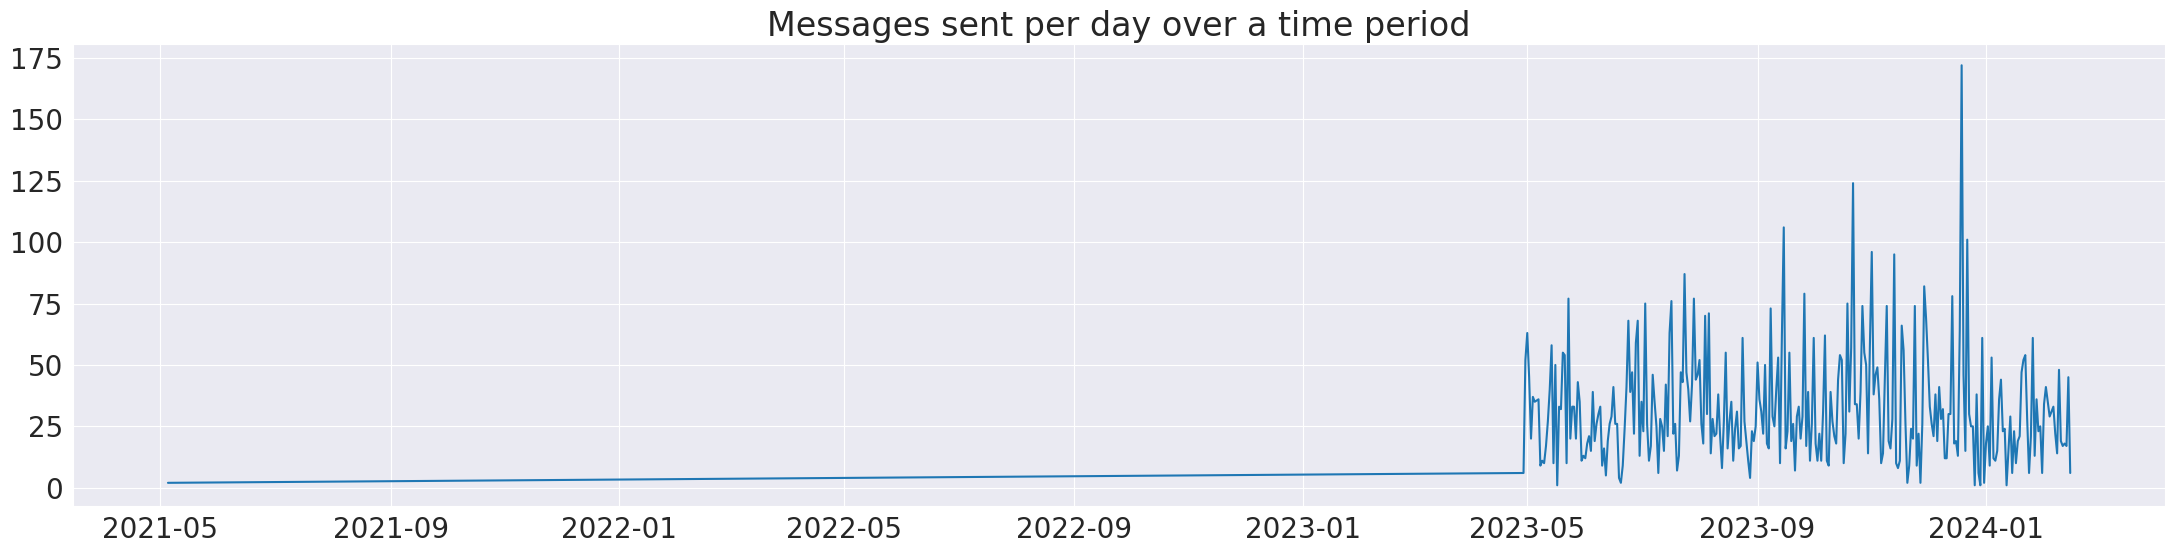

In [57]:

import seaborn as sns
import matplotlib.pyplot as plt


# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

In [58]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2023-12-19,172
1,2023-10-22,124
2,2023-09-15,106
3,2023-12-22,101
4,2023-11-01,96
5,2023-11-13,95
6,2023-07-24,87
7,2023-11-29,82
8,2023-09-26,79
9,2023-12-14,78


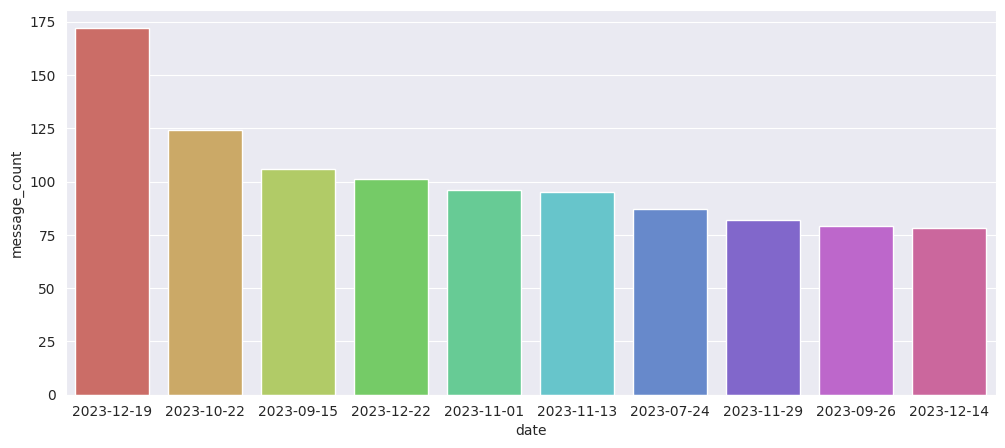

In [59]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 5)

# A bar plot for top 10 days
sns.barplot(x='date', y='message_count', data=top10days, palette="hls")

# Saving the plots
plt.savefig('top10_days.svg', format = 'svg')

In [60]:
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {9 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 7
Number of people who haven't sent even a single message on the group are 0


In [61]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)


top10df = top10df.head(10).reset_index()
top10df

,user,message
0,Davie,2184
1,Mom ❤️🌹,2080
2,Agnes,1999
3,Aggie,760
4,Mike,717
5,Dad ❤️🌹,690
6,Neema 2,573


mostly used emojis using emoji module

In [62]:
from collections import Counter
import emoji
import re

emoji_ctr = Counter()

# Get the list of Unicode emojis
emojis_list = map(lambda x: ''.join(x.split()), emoji.EMOJI_DATA.keys())

# Compile a regex pattern
emoji_pattern = re.compile('|'.join(re.escape(p) for p in emojis_list))

# Count emojis in each message
for idx, row in df.iterrows():
    emojis_in_message = emoji_pattern.findall(row['message'])
    emoji_ctr.update(emojis_in_message)

# Print the emoji count
print(emoji_ctr)


Counter({'😂': 351, '❤️': 144, '🌹': 144, '🌚': 117, '😅': 78, '♀️': 69, '🙆': 43, '✅': 31, '😊': 26, '👯': 22, '🤣': 22, '🏾': 15, '🏽': 14, '😌': 13, '🙆\u200d♂️': 11, '🔥': 9, '🤔': 9, '😁': 7, '☝️': 6, '🙏': 6, '💀': 6, '☺️': 6, '😀': 5, '🤧': 5, '🤦\u200d♂️': 4, '🤷': 4, '👆': 4, '👽': 4, '🙂': 4, '🤬': 3, '😇': 3, '\U0001f972': 3, '😭': 3, '👏': 3, '😥': 3, '🅿️': 3, '🏌🏾\u200d♂️': 3, '😆': 2, '🏿': 2, '🐕': 2, '😃': 2, '🐀': 2, '😄': 2, '😎': 2, '✈️': 1, '🏼': 1, '👍': 1, '🎉': 1, '🤓': 1, '💯': 1, '\U0001faf0': 1, '😮\u200d💨': 1, '🎊': 1, '🤨': 1, '🏠': 1, '😢': 1, '😳': 1, '😐': 1, '🤦': 1, '👌': 1, '⛽': 1, '🤝': 1, '😏': 1})


In [63]:
top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"}) 
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin
    
    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

/tmp/ipykernel_63727/1602179607.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10emojis.emoji[i] = item[0]
/tmp/ipykernel_63727/1602179607.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10emojis.emoji_count[i] = int(item[1])
/tmp/ipykernel_63727/1602179607.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10emojis.emoji_description[i] = description


,emoji,emoji_count,emoji_description
0,😂,351,face_with_tears_of_joy
1,❤️,144,red_heart
2,🌹,144,rose
3,🌚,117,new_moon_face
4,😅,78,grinning_face_with_sweat
5,♀️,69,female_sign
6,🙆,43,person_gesturing_OK
7,✅,31,check_mark_button
8,😊,26,smiling_face_with_smiling_eyes
9,👯,22,people_with_bunny_ears


In [64]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

/tmp/ipykernel_63727/1618280494.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')


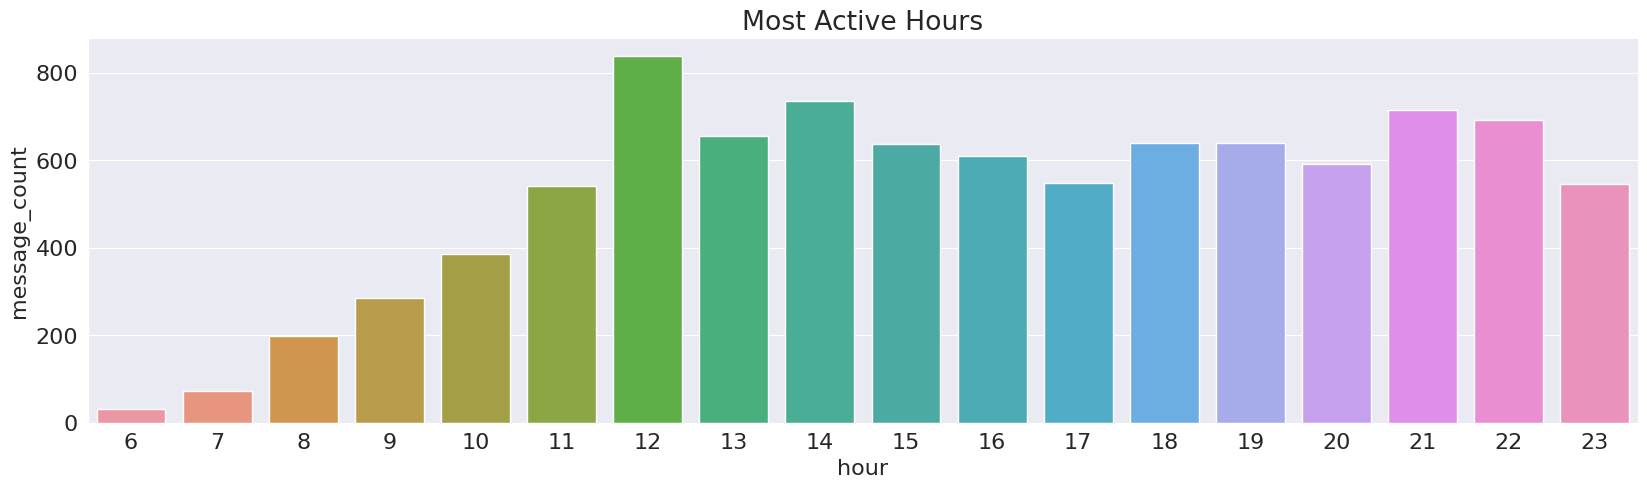

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting font size and figure size
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 5)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(x=grouped_by_time.hour, y=grouped_by_time.message_count)
plt.title('Most Active Hours')

# Saving the plots
plt.savefig('most_active_hours.svg', format='svg')


STOPWORD to display most commonly used word

In [66]:
from wordcloud import WordCloud, STOPWORDS

comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words) 

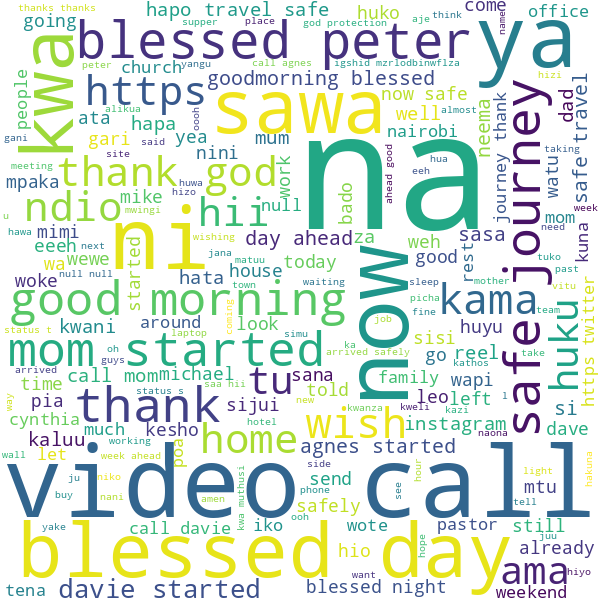

In [67]:
wordcloud.to_image()